<a href="https://colab.research.google.com/github/Valerianko/hrv-stress-detection/blob/main/HRV_Stress_Analysis_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install neurokit2
!pip install nolds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.7/225.7 kB 11.0 MB/s eta 0:00:00


In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import neurokit2 as nk
import nolds
from scipy.signal import welch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from google.colab import drive

In [ ]:
# Монтируем диск
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Настройки
SUBJECT_IDS = ['S2', 'S3', 'S4', 'S5'] # Кого обрабатываем
BASE_PATH = '/content/drive/My Drive/ECG/WESAD/'
SAMPLING_RATE = 700

In [ ]:
# ОПРЕДЕЛЕНИЕ ФУНКЦИЙ

def load_wesad_subject(subject_path):

    # Загрузка сырых данных из .pkl
    with open(subject_path, 'rb') as file:
        data = pickle.load(file, encoding='latin1')
    return data['signal']['chest']['ECG'].flatten(), data['label']

def process_ecg_to_rr(ecg_signal, fs=700):

    # Очистка ЭКГ и получение RR-интервалов
    ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=fs, method="neurokit")
    _, info = nk.ecg_peaks(ecg_cleaned, sampling_rate=fs)
    r_peaks = info["ECG_R_Peaks"]
    # Разница между пиками в секундах * 1000 = мс
    return np.diff(r_peaks) / fs * 1000

def create_windows(df_data, window_size_sec=60, step_size_sec=30, fs=700):

    # Нарезка сигнала на окна с перекрытием
    windows_rr = []
    windows_labels = []
    window_len = window_size_sec * fs
    step = step_size_sec * fs

    for i in range(0, len(df_data) - window_len, step):
        segment = df_data.iloc[i : i + window_len]
        unique_labels = segment['Label'].unique()

        # Берем окно, только если в нем одна метка (чистый класс)
        if len(unique_labels) == 1:
            label = unique_labels[0]
            try:
                rr = process_ecg_to_rr(segment['ECG'].values, fs)
                if len(rr) > 30: # Отбрасываем слишком короткие/шумные
                    windows_rr.append(rr)
                    # 0 - Покой (был 1), 1 - Стресс (был 2)
                    windows_labels.append(0 if label == 1 else 1)
            except:
                continue
    return windows_rr, windows_labels

def extract_features(rr_intervals):
    # Расчет вектора признаков (Линейные + Нелинейные)
    features = {}

    # Time Domain
    features['mean_rr'] = np.mean(rr_intervals)
    features['sdnn'] = np.std(rr_intervals, ddof=1)
    features['rmssd'] = np.sqrt(np.mean(np.diff(rr_intervals)**2))

    # Frequency Domain
    try:
        f, pxx = welch(rr_intervals, fs=1.0, nperseg=min(len(rr_intervals), 256))
        lf_band, hf_band = (0.04, 0.15), (0.15, 0.4)
        lf_power = np.trapz(pxx[(f >= lf_band[0]) & (f <= lf_band[1])], f[(f >= lf_band[0]) & (f <= lf_band[1])])
        hf_power = np.trapz(pxx[(f >= hf_band[0]) & (f <= hf_band[1])], f[(f >= hf_band[0]) & (f <= hf_band[1])])
        features['lf_power'] = lf_power
        features['hf_power'] = hf_power
        features['lf_hf_ratio'] = lf_power / hf_power if hf_power > 0 else 0
    except:
        features['lf_power'] = features['hf_power'] = features['lf_hf_ratio'] = 0

    # Non-linear (Takens)
    try:
        features['sampen'] = nolds.sampen(rr_intervals, emb_dim=2)
        features['corr_dim'] = nolds.corr_dim(rr_intervals, emb_dim=2)
    except:
        features['sampen'] = 0
        features['corr_dim'] = 0

    return features


In [ ]:
# СБОР ДАННЫХ И ПРЕДОБРАБОТКА

all_rr_windows = []
all_labels = []

print(f"Начинаем обработку: {SUBJECT_IDS}")

for sub_id in SUBJECT_IDS:
    path = os.path.join(BASE_PATH, sub_id, f"{sub_id}.pkl")
    if not os.path.exists(path):
        print(f"Файл {sub_id} не найден.")
        continue

    print(f"-> Обработка {sub_id}...")
    try:
        ecg, labels = load_wesad_subject(path)
        df = pd.DataFrame({'ECG': ecg, 'Label': labels})
        # Оставляем только Baseline(1) и Stress(2)
        df = df[df['Label'].isin([1, 2])].copy()

        # Режем на окна
        rr, labs = create_windows(df)
        all_rr_windows.extend(rr)
        all_labels.extend(labs)
        print(f"   Окон: {len(rr)}")
        del df, ecg, labels # Чистим память
    except Exception as e:
        print(f"   Ошибка: {e}")

print(f"Всего окон: {len(all_rr_windows)}. (0-Покой: {all_labels.count(0)}, 1-Стресс: {all_labels.count(1)})")

Начинаем обработку: ['S2', 'S3', 'S4', 'S5']
-> Обработка S2...
   Окон: 55
-> Обработка S3...
   Окон: 57
-> Обработка S4...
   Окон: 56
-> Обработка S5...
   Окон: 58
Всего окон: 226. (0-Покой: 149, 1-Стресс: 77)


In [ ]:
# ИЗВЛЕЧЕНИЕ ПРИЗНАКОВ И ОБУЧЕНИЕ

print("\n Расчет признаков (это может занять время)...")
X_data = [extract_features(win) for win in all_rr_windows]
X = pd.DataFrame(X_data)
y = np.array(all_labels)

# Очистка от бесконечностей
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)

print("\n Обучение модели...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


 Расчет признаков (это может занять время)...


/tmp/ipython-input-3560596800.py:54: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  lf_power = np.trapz(pxx[(f >= lf_band[0]) & (f <= lf_band[1])], f[(f >= lf_band[0]) & (f <= lf_band[1])])
/tmp/ipython-input-3560596800.py:55: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  hf_power = np.trapz(pxx[(f >= hf_band[0]) & (f <= hf_band[1])], f[(f >= hf_band[0]) & (f <= hf_band[1])])
/tmp/ipython-input-3560596800.py:54: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  lf_power = np.trapz(pxx[(f >= lf_band[0]) & (f <= lf_band[1])], f[(f >= lf_band[0]) & (f <= lf_band[1])])
/tmp/ipython-input-3560596800.py:55: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `sc


 Обучение модели...


In [ ]:
# Результаты
print("\n" + "="*30)
print("РЕЗУЛЬТАТЫ КЛАССИФИКАЦИИ")
print("="*30)
print(classification_report(y_test, y_pred, target_names=['Покой', 'Стресс']))


РЕЗУЛЬТАТЫ КЛАССИФИКАЦИИ
              precision    recall  f1-score   support

       Покой       0.95      0.97      0.96        39
      Стресс       0.94      0.89      0.91        18

    accuracy                           0.95        57
   macro avg       0.95      0.93      0.94        57
weighted avg       0.95      0.95      0.95        57



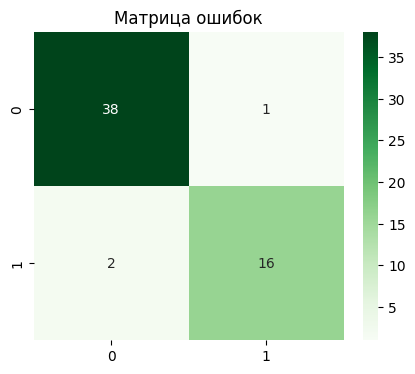

In [ ]:
# 1. Матрица ошибок
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
plt.title('Матрица ошибок')
plt.show()

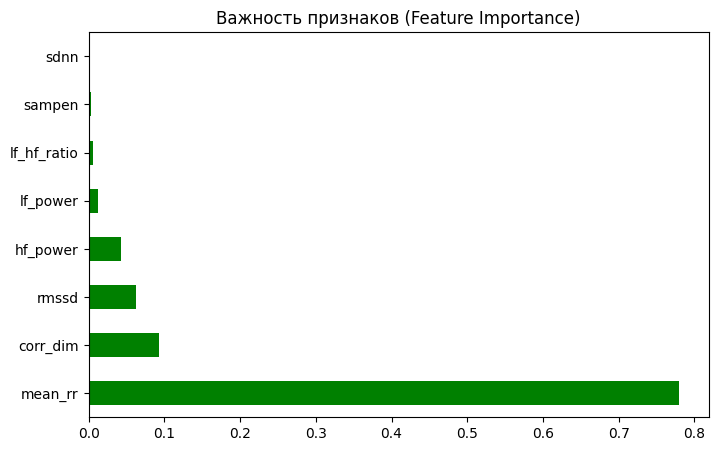

In [ ]:
# 2. Важность признаков
plt.figure(figsize=(8, 5))
pd.Series(model.feature_importances_, index=X.columns).nlargest(10).plot(kind='barh', color='green')
plt.title('Важность признаков (Feature Importance)')
plt.show()

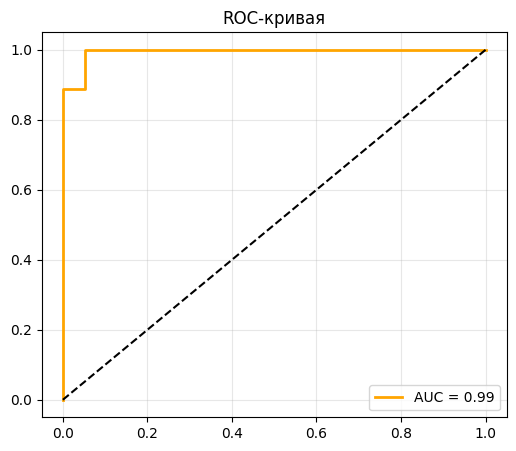

In [ ]:
# 3. ROC-кривая
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'AUC = {auc(fpr, tpr):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC-кривая')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


 Генерация аттракторов...


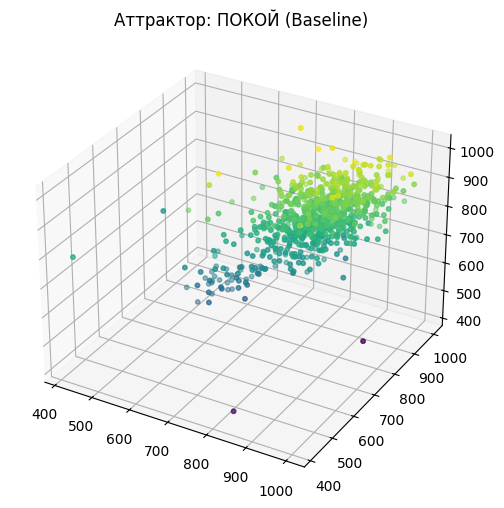

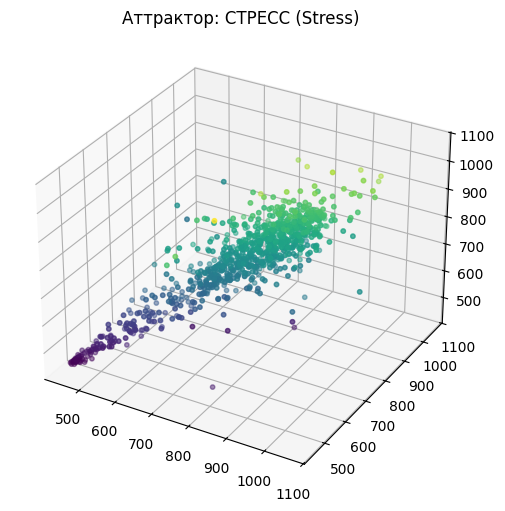

In [ ]:
# 4. Агрегированные Аттракторы (Красивые 3D графики)
def plot_3d_attractor(label_code, title_text, limit=20):
    indices = [i for i, x in enumerate(all_labels) if x == label_code][:limit]
    data = []
    for i in indices: data.extend(all_rr_windows[i])
    data = np.array(data)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:-2], data[1:-1], data[2:], c=data[2:], cmap='viridis', s=10, alpha=0.5)
    ax.set_title(title_text)
    plt.show()

print("\n Генерация аттракторов...")
plot_3d_attractor(0, "Аттрактор: ПОКОЙ (Baseline)")
plot_3d_attractor(1, "Аттрактор: СТРЕСС (Stress)")

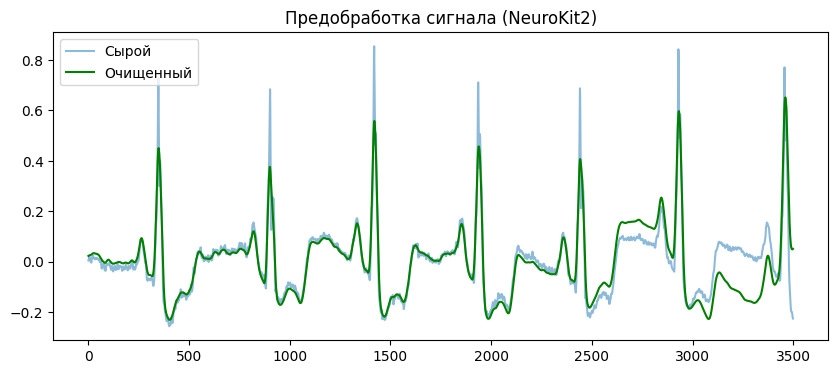

In [ ]:
# 5. График фильтрации (Сырой vs Чистый) - берем кусочек из S2
if os.path.exists(os.path.join(BASE_PATH, 'S2', 'S2.pkl')):
    raw_ecg, _ = load_wesad_subject(os.path.join(BASE_PATH, 'S2', 'S2.pkl'))
    # Берем кусочек 5 сек
    raw_seg = raw_ecg[10000:10000+700*5]
    clean_seg = nk.ecg_clean(raw_seg, sampling_rate=700)

    plt.figure(figsize=(10, 4))
    plt.plot(raw_seg, label='Сырой', alpha=0.5)
    plt.plot(clean_seg, label='Очищенный', color='green')
    plt.title('Предобработка сигнала (NeuroKit2)')
    plt.legend()
    plt.show()

In [ ]:
# ПРОТОТИП (ФИНАЛЬНАЯ ФУНКЦИЯ)

def stress_analysis_software(ecg_signal_segment, sampling_rate=700):
    """
    Эмуляция работы готового ПО.
    На вход подается кусок сигнала ЭКГ (например, 1 минута).
    На выходе -  лог и вердикт.
    """
    print("--- ЗАПУСК АНАЛИЗА ---")

    # 1. Препроцессинг
    try:
        # Очистка и поиск пиков
        cleaned = nk.ecg_clean(ecg_signal_segment, sampling_rate=sampling_rate, method="neurokit")
        _, info = nk.ecg_peaks(cleaned, sampling_rate=sampling_rate)
        r_peaks = info["ECG_R_Peaks"]

        # Расчет RR-интервалов
        rr_intervals = np.diff(r_peaks) / sampling_rate * 1000

        # Проверка качества
        if len(rr_intervals) < 20:
            print("Ошибка: Недостаточно данных или сильные шумы.")
            return None

    except Exception as e:
        print(f"Ошибка обработки сигнала: {e}")
        return None

    # 2. Извлечение признаков
    features = extract_features(rr_intervals)

    # Подготовка таблицы для модели
    features_df = pd.DataFrame([features])
    features_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    features_df.fillna(0, inplace=True)

    # 3. Предсказание
    prediction = model.predict(features_df)[0]
    probability = model.predict_proba(features_df)[0]

    # 4. Формирование вывода
    result_class = "СТРЕСС" if prediction == 1 else "ПОКОЙ"
    confidence = probability[prediction] * 100

    print(f"Результат диагностики: {result_class}")
    print(f"Уверенность модели:    {confidence:.1f}%")
    print("-" * 20)
    print("Ключевые показатели:")

    # Выводим самые важные метрики для врача/пользователя
    print(f" - Пульс (уд/мин):      {60000/features['mean_rr']:.1f}")
    print(f" - Вариабельность (SDNN): {features['sdnn']:.1f} мс")
    print(f" - Индекс стресса (LF/HF): {features['lf_hf_ratio']:.2f}")
    print(f" - Сложность (SampEn):  {features['sampen']:.3f}")
    print("----------------------")

    return prediction

# ТЕСТ ПРОТОТИПА НА РЕАЛЬНЫХ ДАННЫХ

# 1. Загружаем данные одного субъекта (например, S2) для теста
test_path = os.path.join(BASE_PATH, 'S2', 'S2.pkl')

if os.path.exists(test_path):
    print("\n>>> Пользователь загрузил данные с устройства...")

    # Загружаем полный сигнал
    ecg_full, labels_full = load_wesad_subject(test_path)

    # 2. Вырезаем кусочек, где точно был СТРЕСС (Label = 2)
    # Ищем индексы стресса
    stress_indices = np.where(labels_full == 2)[0]

    if len(stress_indices) > 0:
        # Берем точку в середине стрессовой сессии
        start_point = stress_indices[len(stress_indices)//2]
        # Вырезаем 60 секунд (700 отсчетов * 60 сек)
        segment_real = ecg_full[start_point : start_point + 700*60]


        _ = stress_analysis_software(segment_real)
    else:
        print("В файле S2 нет разметки стресса для теста.")
else:
    print(f"Файл {test_path} не найден. Проверьте путь к Google Drive.")


>>> Пользователь загрузил данные с устройства...
--- ЗАПУСК АНАЛИЗА ---
Результат диагностики: СТРЕСС
Уверенность модели:    99.9%
--------------------
Ключевые показатели:
 - Пульс (уд/мин):      76.3
 - Вариабельность (SDNN): 41.1 мс
 - Индекс стресса (LF/HF): 5.04
 - Сложность (SampEn):  1.558
----------------------


/tmp/ipython-input-3560596800.py:54: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  lf_power = np.trapz(pxx[(f >= lf_band[0]) & (f <= lf_band[1])], f[(f >= lf_band[0]) & (f <= lf_band[1])])
/tmp/ipython-input-3560596800.py:55: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  hf_power = np.trapz(pxx[(f >= hf_band[0]) & (f <= hf_band[1])], f[(f >= hf_band[0]) & (f <= hf_band[1])])
